# 변동성 변동을 동적으로 조정하는 평균회귀 전략

- stdev 지표 사용 

In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import statistics as stats
import math as math
import matplotlib.pyplot as plt

In [2]:
# 4개년 일간 데이터 가져오기
SYMBOL='GOOG'
start_date = '2017-01-01'
end_date = '2021-01-01'
SRC_DATA_FILENAME=SYMBOL + '_data.pkl'


data = pdr.DataReader(SYMBOL, 'yahoo', start_date, end_date)

In [3]:
# EMA 계산을 위한 상수/변수
NUM_PERIODS_FAST = 10               # 빠른 EMA 정적 기간 파라미터 ( APO시그널 +10 초과시 매도, -10 아래시 매수 )
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # 빠른 EMA를 위한 정적 평활화 팩터
ema_fast = 0
ema_fast_values = []                # 시각화를위해 값 보존

NUM_PERIODS_SLOW = 40               # 느린 EMA 정적 기간 파라미터
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # 느린 EMA를 위한 정적 평활화 팩터
ema_slow = 0
ema_slow_values = []                # 시각화를 위해 값 보존

apo_values = []                     # 계산된 APO값 시그널을 추적

In [4]:
# 트레이딩 전략 트레이드, 포지션과 pnl 관리를 위한 변수
orders = []    # 매수/매도 주문을 위한 변수로서 매수 주문에 대해서는 +1, 매도 주문에 대해서는 -1, 없으면 0
positions = [] # 포지션을 추적하는 변수
pnls = []      # 총 손익(pnl)을 추적하는 변수 (closed_pnl + open_pnl)

last_buy_price = 0     # 마지막 매수 트레이드의 가격으로 동일한 가격 또는 주변 가격으로 과다 트레이딩하는 것 방지
last_sell_price = 0    # 
position = 0           # 현재 포지션
buy_sum_price_qty = 0  # 마지막으로 포지션이 청산된 이후 수행된 모든 거래에 대한 매수 거래가격과 매수 거래량 곱의 합
buy_sum_qty = 0        # 마지막으로 포지션이 청산된 이후 수행된 모든 거래에 대한 매수 거래량의 곱의 합
sell_sum_price_qty = 0 # 
sell_sum_qty = 0       # 
open_pnl = 0           # 시장 연된된 미체결/미실현 pnl
closed_pnl = 0         # 이제까지 체결/실현된 pnl0

In [5]:
# 전략 행태/임계값을 정의하는 상수들
APO_VALUE_FOR_BUY_ENTRY = -10       # APO 트레이딩 시그널 아래에서 매수 주문/롱 포지션에 들어가는
APO_VALUE_FOR_SELL_ENTRY = 10       # APO 트레이딩 시그널 위에서 매도 주문/롱 포지션 들어가는
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # 트레이딩 재개하기 이전 마지막 거래로부터의 최소 가격 변화, 동일한 가격 또는 그 주변 가격 과다 트레이딩 막기 위해
NUM_SHARES_PER_TRADE = 10           # 포지션을 청산하고 이익을 고정시키는 최소 미체결/미실현 이익
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # 모든 트레이드에 있어서 최소 매수/매도 주수


In [6]:
# 변동성 척도로 표준편차를 계산하고자 사용하는 상수/변수
SMA_NUM_PERIODS = 20 # 룩백기간
price_history = []   # 가격 히스토리

- 빠르고 느린 EMA에 대해 정적 K_FAST 및 K_SLOW 평활 계수를 사용하는 대신 이들을 변동성의 함수로 만들고,
- K_FAST*stdev_factor 및 K_SLOW*stdev_factor를 사용해 변동성이 정상보다 높은 기간 동안 최신 관찰값에 대해 더 반응하도록 만든다..
- 정적 APO_VALUE_FOR_BUR_ENTRY 및 SELL 임계값을 사용하는 대신 동적 임계값 APO_VALUE_FOR_BUY_ENTRY*stdev_factor 및 sell 를 갖도록 변동성 통합
- 이는 변동성 비율로 진입 임계값을 증가시킴으로써 변동성이 높은 기간 동안 포지션에 짙입하는 것을 덜 공격적으로 만들며 apo트레이딩 시그널 평균회귀 전략 참고

In [7]:
close=data['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS: # 적어도 설정된 기간의 가격 수만큼은 추적
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0                             # 분산은 표준편차의 제곱
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15    # 변동성 척도가 20일8~40 범위, 15가 평균인거 같아서 # 표준편차 지표 참고!! 
    if stdev_factor == 0:
        stdev_factor = 1

    # 빠른/느린 ema를 업데이트하고 apo 트레이딩 시그널을 계산
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # 조건 만족하면, 종가로 매도 거래를 수행
    # 1. APO 트레이딩 시그널 값이 매도 진입 임계값을 넘고, 마지막 거래 가격과 현재 가격의 차이가 충분히 다르다.
    # 2. 롱 포지션이고, APO 트레이딩 값이 0 이상이거나 현재의 포지션이 고정시킬 만큼의 이익을 내고 있다.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO가 매도 진입 임걔값을 넘으면 매도한다.
        or
        (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # 롱포지션이고, APO가 음에서 양으로 변화하거나 포지션이 이익이 나면 포지션을 청산하고자 매도
        orders.append(-1) # 매도 거래를 표시
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE                         # 이 거래만큼 포지션을 줄인다.
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # VWAP 매도 가격을 업데이트한다.
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

        # 조건 만족하면 종가로 매수 거래 수행
        # 1. APO 트레이딩 시그널 값이 매수 진입 임계값을 넘고, 마지막 거래 가격과 현재 가격의 차이가 충분히 다르다.
        # 2. 숏 포지션이고, APO 트레이딩 값이 0 이하이거나 현재의 포지션이 고정시킬 만큼의 이익을 내고 있다.
    elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO가 매수 진입 임계값을 하회하면 매수
        or
        (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # 숏 포지션이고, APO가 양에서 음으로 변화하거나 포지션이 이익이 나면 포지션을 청산하고 매수
        orders.append(+1) # 매수 거래를 표시
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # 이 거래만큼 포지션을 줄인다.
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # VWAP 매도 가격을 업데이트
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # 매수 또는 매도를 위한 어떤 조건도 만족하지 않으므로 거래를 하지 않는다.
        orders.append(0)

    positions.append(position)

    # 미체결/미실현과 체결/실현 포지션 업데이트
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # 롱 포지션과 이에 대한 매도 거래가 수행되며, 이 롱 포지션에 대해 얼마만큼 매도하는가를 기반으로 그만큼 청산
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # 잔여 포지션을 시장 가격으로 평가, 손익은 현재 가격에 청산된다면 계산됐을 손익
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # 숏 포지션과 이에 대한 매수 거래가 수행, 이 숏 포지션에 대해 얼마만큼 매수하는가를 기반으로 그만큼 청산
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
            # 잔여 포지션을 시장가격으로 평가
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # 포지션이 없으면 청산된 손익을 업데이트하고, 포지션과 PNLS을 추적하기 위한 변수들을 재설정
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  806.3599853515625 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  -15.2001953125  ClosedPnL:  0  TotalPnL:  -15.2001953125
OpenPnL:  17.5  ClosedPnL:  0  TotalPnL:  17.5
OpenPnL:  2.8997802734375  ClosedPnL:  0  TotalPnL:  2.8997802734375
OpenPnL:  41.8499755859375  ClosedPnL:  0  TotalPnL:  41.8499755859375
OpenPnL:  13.399658203125  ClosedPnL:  0  TotalPnL:  13.399658203125
Sell  10  @  819.3099975585938 Position:  -20
OpenPnL:  -129.5001220703125  ClosedPnL:  0  TotalPnL:  -129.5001220703125
OpenPnL:  -220.7000732421875  ClosedPnL:  0  TotalPnL:  -220.7000732421875
Sell  10  @  835.6699829101562 Position:  -30
OpenPnL:  -456.6998291015625  ClosedPnL:  0  TotalPnL:  -

In [8]:
# 전략 결과 데이터프레임 준비
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

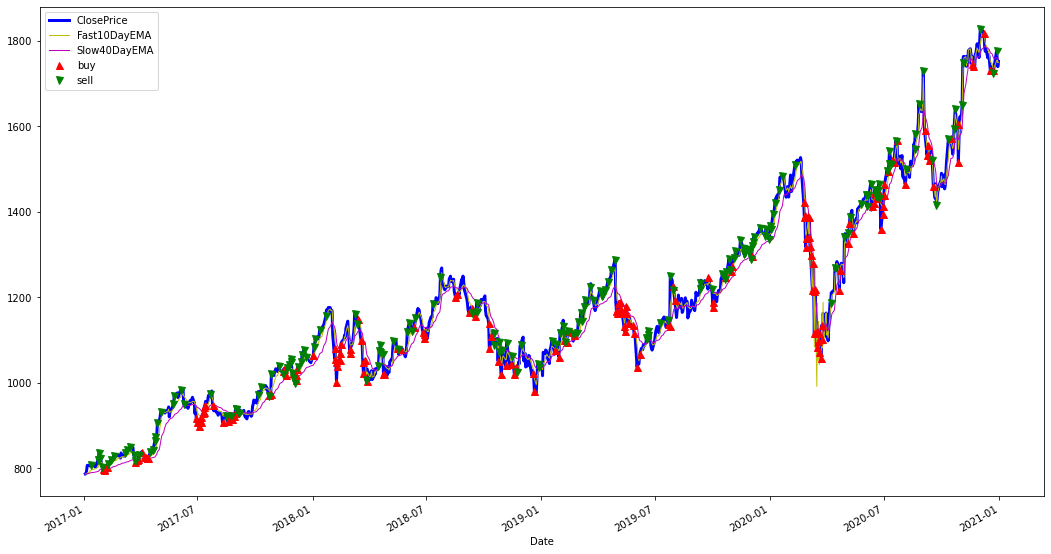

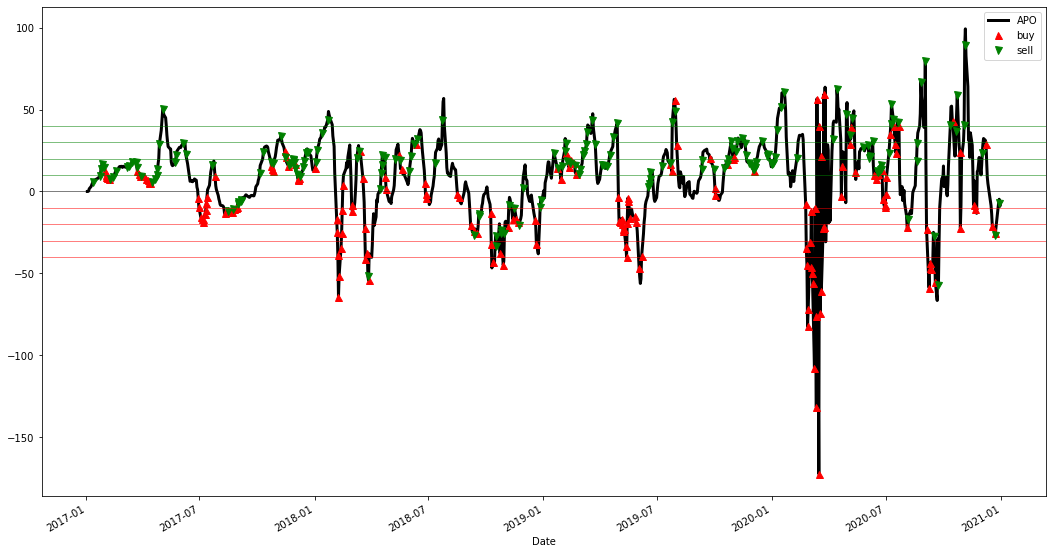

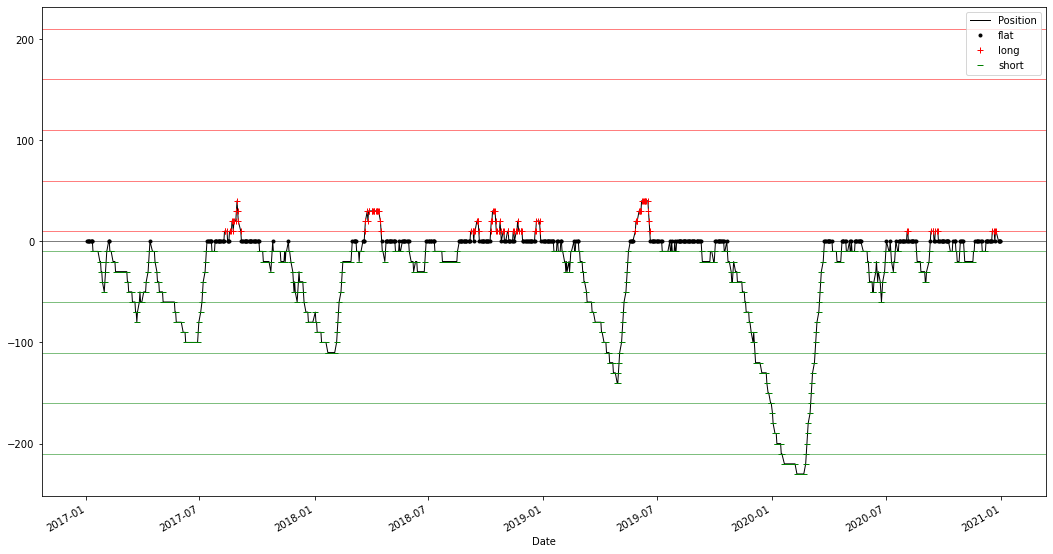

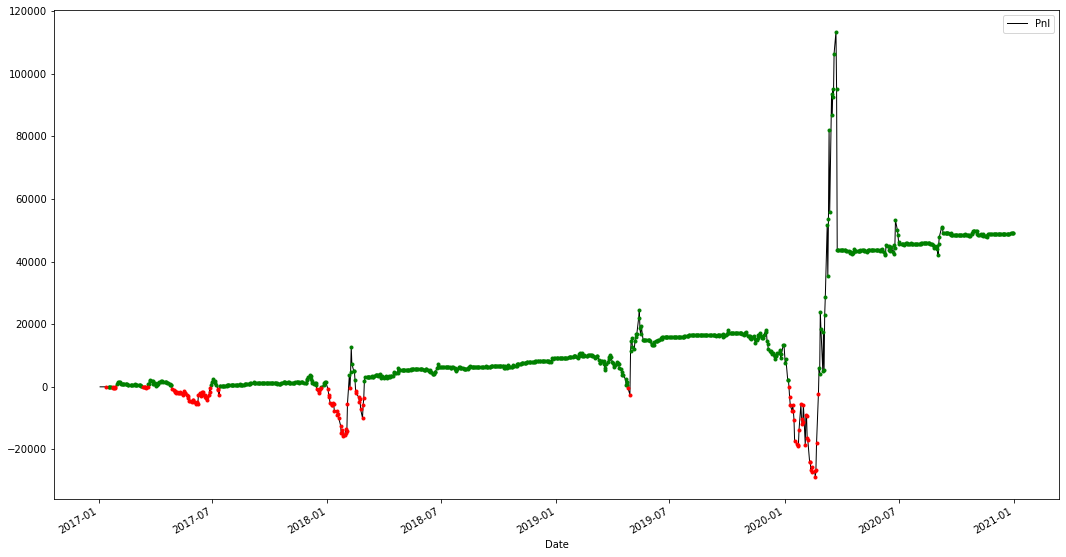

In [9]:
plt.figure(figsize=(18,10))
data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()


In [ ]:
data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")